<a href="https://colab.research.google.com/github/RabinSharma25/emotion-classification-using-eeg-signals/blob/main/4_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries
import os
import time
import pickle
import pandas as pd
import numpy as np
from google.colab import drive

#for feature extraction
from scipy.signal import welch
from scipy.integrate import simps

#classifier libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [2]:
def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [3]:
#creating the file names of the dataset to load it
files = []
for n in range (1, 33):
    s = 's'
    if n < 10:
        s += '0'
    s += str(n)
    s+=str(".dat")
    files.append(s)
print(files)

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [4]:
# 32x40 = 1280 trials for 32 participants
labels = []
data = []
drive.mount('/content/drive')
for i in files:
  filename = "/content/drive/My Drive/major-project/major-project-dataset/" + i
  trial = read_data(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])


Mounted at /content/drive


In [5]:
# Lets see the shapes of the raw data
labels = np.array(labels)
data = np.array(data)
print("Labels: ", labels.shape) # participants x videos x labels
print("Data: ", data.shape) # participants x videos x channels x data

Labels:  (32, 40, 4)
Data:  (32, 40, 40, 8064)


In [6]:
# Re-shape arrays into desired shapes
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [7]:
# Double-check the new arrays
#Here trial = participants x vidoes = 32 x 40 = 1280

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [8]:
#creating the dataframes for the labels
labelsDf = pd.DataFrame(labels)
print("printing the labels dataframe\n")
print(labelsDf)
print("\n\nDescribing the labels dataframe")
labelsDf.describe()

printing the labels dataframe

         0     1     2     3
0     7.71  7.60  6.90  7.83
1     8.10  7.31  7.28  8.47
2     8.58  7.54  9.00  7.08
3     4.94  6.01  6.12  8.06
4     6.96  3.92  7.19  6.05
...    ...   ...   ...   ...
1275  3.91  6.96  5.82  3.12
1276  2.81  6.13  6.06  1.04
1277  3.05  7.01  5.10  1.10
1278  3.99  7.17  4.85  1.00
1279  7.15  4.03  9.00  1.88

[1280 rows x 4 columns]


Describing the labels dataframe


,0,1,2,3
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [9]:
#giving names to the label columns
df_labels= pd.DataFrame({'valence': labels[:,0], 'arousal': labels[:,1], 'dominance': labels[:,2], 'liking': labels[:,3]})
print(labelsDf.describe())


                 0            1            2            3
count  1280.000000  1280.000000  1280.000000  1280.000000
mean      5.254313     5.156711     5.382750     5.518133
std       2.130816     2.020499     2.096321     2.282780
min       1.000000     1.000000     1.000000     1.000000
25%       3.867500     3.762500     3.932500     3.960000
50%       5.040000     5.230000     5.240000     6.050000
75%       7.050000     6.950000     7.040000     7.090000
max       9.000000     9.000000     9.000000     9.000000


In [10]:
#Dropping the Dominance and Liking columns
df_labels=df_labels.drop('dominance',axis=1)
df_labels=df_labels.drop('liking',axis=1)
# print(df_labels.describe())
print(df_labels)
# df = df.drop('B', axis=1)

      valence  arousal
0        7.71     7.60
1        8.10     7.31
2        8.58     7.54
3        4.94     6.01
4        6.96     3.92
...       ...      ...
1275     3.91     6.96
1276     2.81     6.13
1277     3.05     7.01
1278     3.99     7.17
1279     7.15     4.03

[1280 rows x 2 columns]


# Separte Valence and Arousal to HAHV, LAHV, HALV, LALV

In [11]:
import numpy as np

# # Create a sample DataFrame with 'valence' and 'arousal' columns
# np.random.seed(0)
# valence = np.random.uniform(1, 9, 1280)
# arousal = np.random.uniform(1, 9, 1280)
# data = {'valence': valence, 'arousal': arousal}
# df_valence_arousal = pd.DataFrame(data)

# Calculate the median value of arousal and valence column
arousal_median = df_labels['arousal'].median()
print(arousal_median)
valence_median = df_labels['valence'].median()
print(valence_median)

# Create a new DataFrame with the desired columns
df_result = pd.DataFrame(index=range(1280), columns=['HAHV', 'LAHV', 'HALV', 'LALV'])
df_result[['HAHV', 'LAHV', 'HALV', 'LALV']] = 0

# Apply the conditions
df_result.loc[(df_labels['valence'] >= valence_median) & (df_labels['arousal'] >= arousal_median), 'HAHV'] = 1
df_result.loc[(df_labels['arousal'] < arousal_median) & (df_labels['valence'] >= valence_median), 'LAHV'] = 1
df_result.loc[(df_labels['arousal'] >= arousal_median) & (df_labels['valence'] < valence_median), 'HALV'] = 1
df_result.loc[(df_labels['valence'] < valence_median) & (df_labels['arousal'] < arousal_median), 'LALV'] = 1

# Show the first few rows of the result DataFrame
# df_result.tail()
print(df_result)


5.23
5.04
      HAHV  LAHV  HALV  LALV
0        1     0     0     0
1        1     0     0     0
2        1     0     0     0
3        0     0     1     0
4        0     1     0     0
...    ...   ...   ...   ...
1275     0     0     1     0
1276     0     0     1     0
1277     0     0     1     0
1278     0     0     1     0
1279     0     1     0     0

[1280 rows x 4 columns]


Verify the data in 4 classes

In [12]:
# Check the number of 1s in each individual column
count_HAHV = df_result['HAHV'].sum()
count_LAHV = df_result['LAHV'].sum()
count_HALV = df_result['HALV'].sum()
count_LALV = df_result['LALV'].sum()

print(f"Number of 1s in HAHV: {count_HAHV}")
print(f"Number of 1s in LAHV: {count_LAHV}")
print(f"Number of 1s in HALV: {count_HALV}")
print(f"Number of 1s in LALV: {count_LALV}")

print(f"Total = {count_HAHV+count_LAHV+count_HALV+count_LALV}") # the total must be 1280


Number of 1s in HAHV: 358
Number of 1s in LAHV: 322
Number of 1s in HALV: 282
Number of 1s in LALV: 318
Total = 1280


In [13]:
# Dataset with only Valence column
df_val = df_labels['valence']
# Dataset with only Arousal column
df_aro = df_labels['arousal']

In [14]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [15]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
    labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["High Valence", "High Arousal"])
print(df_labels.describe())
print(df_labels)

       High Valence  High Arousal
count   1280.000000   1280.000000
mean       0.531250      0.500000
std        0.499218      0.500195
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000      0.500000
75%        1.000000      1.000000
max        1.000000      1.000000
      High Valence  High Arousal
0                1             1
1                1             1
2                1             1
3                0             1
4                1             0
...            ...           ...
1275             0             1
1276             0             1
1277             0             1
1278             0             1
1279             1             0

[1280 rows x 2 columns]


In [16]:
# Dataset with only Valence column
df_valence = df_labels['High Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']
print(df_valence)
print(df_valence.shape)

0       1
1       1
2       1
3       0
4       1
       ..
1275    0
1276    0
1277    0
1278    0
1279    1
Name: High Valence, Length: 1280, dtype: int64
(1280,)


# FEATURE EXTRACTION USING WELCH'S METHOD

In [17]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [18]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [19]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


In [20]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [21]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)

  return bandpower(eeg_data[trial,channel], 128, bd)


In [22]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


# Process new datasets with 6 EEG regions and 4 band power values

In [23]:
# Transform 1280x 32 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (1280, 128))

In [24]:
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [25]:
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count   1280.000000   1280.000000   1280.000000   1280.000000   1280.000000   
mean     517.431002    974.493856    795.093910   1515.004071    746.435950   
std     1165.295163   3147.555132   3020.711666   4990.544508   2188.101734   
min        2.698928      1.995398      1.820656      3.283107      1.311200   
25%       23.306027     17.117475     18.392335     30.827191     14.023436   
50%       65.468048     82.102529     60.241953     91.266539     48.704968   
75%      331.636624    304.949248    175.394835    248.308696    218.358248   
max    15524.135098  38122.870846  39431.320394  49272.793208  20182.668545   

               FC1            C3           T7           CP5          CP1  ...  \
count  1280.000000   1280.000000  1280.000000   1280.000000  1280.000000  ...   
mean    345.936665    486.095113   354.004358    664.656754   276.667812  ...   
std     717.328768   1497.636647   641.432373

In [26]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (1280, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

               Fp1           AF3            F3            F7          FC5  \
count  1280.000000   1280.000000   1280.000000   1280.000000  1280.000000   
mean    173.544174    333.184883    285.545436    573.725974   249.793720   
std     378.371554   1058.758333   1036.330438   1943.692827   702.436934   
min       2.770151      1.793012      1.724442      2.793554     0.975527   
25%      14.082681     10.737435     10.012318     15.888935    10.074042   
50%      33.713172     34.992442     30.026795     38.178299    20.079100   
75%     125.508396    114.334883     73.488279     93.987498    74.040939   
max    5627.906982  12380.702125  12764.724842  20843.070851  6575.781434   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean    138.011594   170.423962   124.101183   232.750895    97.610644  ...   
std     275.218934   497.507620   200.171342   735.717912   166.43002

In [27]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (1280, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               Fp1          AF3           F3            F7          FC5  \
count  1280.000000  1280.000000  1280.000000   1280.000000  1280.000000   
mean     92.200266   200.684361   193.372441    341.951096   140.642394   
std     176.162562   668.027842   668.771074   1274.679748   386.740178   
min       4.486703     2.650970     2.784376      3.363422     2.788531   
25%      17.999409    13.190613    10.170223     17.951892    11.341571   
50%      34.413828    29.155242    28.120517     33.617573    22.402198   
75%      80.774739   107.619088    59.807546     62.087123    53.162211   
max    3528.485435  5784.160193  5841.475721  14848.700463  3094.687504   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     99.397187    96.901859    77.540922   137.387625    55.047411  ...   
std     197.556641   247.621839    90.107877   409.366974    85.846400  ...   
min     

In [28]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (1280, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               Fp1          AF3           F3           F7          FC5  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000   
mean     50.663247   150.492372   149.210824   122.775294    91.633571   
std     135.591365   645.635199   632.049548   496.744509   340.562025   
min       1.069233     1.119910     0.791859     1.177512     0.712624   
25%       8.292302     5.605668     4.352724     7.591098     5.172920   
50%      18.329100    14.069330    11.828027    15.919877    12.648067   
75%      39.995543    43.454610    28.586812    36.456420    38.094737   
max    3213.255538  6060.539788  5758.756812  6348.177208  3472.515858   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     60.487715    56.236468    43.792285    77.048369    29.250057  ...   
std     139.230040   180.285647    62.089299   267.809883    68.503827  ...   
min       0.69492

In [29]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return x_train, x_test, y_train, y_test

In [30]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

In [31]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["frontal",  "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [32]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'rbf',random_state = 42, probability=True)

In [33]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [34]:
clf_dtree=DecisionTreeClassifier(max_depth=20,min_samples_split=4)

In [35]:
clf_rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)

In [36]:
clf_nb= GaussianNB()

In [37]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [38]:
clf_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)


In [39]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)


In [40]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()

In [41]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
clf_gpc = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), random_state=42)


In [42]:
from sklearn.linear_model import Perceptron
clf_perceptron = Perceptron(random_state=42)

In [43]:
!pip install catboost
import catboost as cb
clf_catboost = cb.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.6 MB/s eta 0:00:00


In [44]:
#define cnn model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

def create_cnn_model(data_np):
    model = Sequential([
        Input(shape=(data_np.shape[1], 1)),  # Adjusted to match data_np shape
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(2, activation='softmax')
    ])
    return model

def train_and_evaluate_cnn(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for CNN: (number of samples, height, width, channels)
    # Here, height=1, width=number of features, channels=1
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.20, random_state=42)

    # Define the CNN model
    model = create_cnn_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    # test_loss, test_accuracy = model.evaluate(X_test, y_test)

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)


    return y_true,y_pred_classes


In [45]:
#define ann model
def create_ann_model(data_scaled):
    model = Sequential([
        Dense(64, input_dim=data_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model


def train_and_evaluate_ann(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_np)

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels_encoded, test_size=0.2, random_state=42)

    # Define the CNN model
    model = create_ann_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    # test_loss, test_accuracy = model.evaluate(X_test, y_test)


    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    return y_true,y_pred_classes

In [46]:
#define lstm model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


def create_lstm_model(data_np):
    model = Sequential([
    LSTM(20, input_shape=(data_np.shape[1], 1)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Assuming two classes: 0 and 1
    ])
    return model

def train_and_evaluate_lstm(df_x, df_y):
    # Convert dataframes to numpy arrays
    data_np = df_x.values
    labels_np = df_y.values

    # Reshape data for LSTM: (samples, time_steps, features)
    # Here, each row is treated as a sequence with a single time step
    data_reshaped = data_np.reshape((data_np.shape[0], data_np.shape[1], 1))

    # One-hot encode the labels
    labels_encoded = to_categorical(labels_np)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_reshaped, labels_encoded, test_size=0.2, random_state=42)
    # Define the CNN model
    model = create_lstm_model(data_np)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model on the test set
    # test_loss, test_accuracy = model.evaluate(X_test, y_test)
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)


    return y_true,y_pred_classes




In [47]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('DT', clf_dtree))
models.append(('RF', clf_rf))
models.append(('NB', clf_nb))
models.append(('MLP', clf_mlp))
models.append(('AB', clf_adaboost))
models.append(('XGB', clf_xgb))

In [48]:
!pip install imbalanced-learn

In [49]:

from imblearn.over_sampling import SMOTE
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  # df_y = df_arousal if (label == "arousal") else df_valence
  # print(df_y.shape)
  # df_y = df_result["HAHV"]
  # df_y = df_result
  # df_y = df_y.flatten
  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  if (label == "HAHV"):
    df_y = df_result["HAHV"]
  elif (label == "LAHV"):
    df_y = df_result["LAHV"]
  elif (label == "HALV"):
    df_y = df_result["HALV"]
  elif (label == "LALV"):
    df_y = df_result["LALV"]

  # print(f"the shape of df_y is {df_y.shape}")
  # print(f"the shape of df_x is {df_x.shape}")
  # Train-test split

  # save he dataframes in csv format for analysis
  # if (band == "gamma" and channel == "frontal" and label == "HALV"):
  #   df_y.to_csv('labels.csv', index=False)
  #   print("DataFrame saved to 'labels.csv'")
  #   df_x.to_csv('data.csv', index=False)
  #   print("DataFrame saved to 'data.csv'")
  #   from google.colab import files
  #   files.download('labels.csv')
  #   files.download('data.csv')

  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)

  # Apply SMOTE to upsample the minority class in the training set
  # smote = SMOTE(random_state=42)
  # X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

  # Apply CV
  x_for_kfold = np.array(x_train)
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=10)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]

  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  # Feature scaling
  scaler = StandardScaler()
  x_train2 = scaler.fit_transform(x_train2)
  x_test2 = scaler.transform(x_test2)

  # x_train2 = X_train_resampled
  # x_test2 = x_test
  # y_train2 = y_train_resampled
  # y_test2 = y_test

  # Standardize the features
  # scaler = StandardScaler()
  # X_train_resampled = scaler.fit_transform(X_train_resampled)
  # x_test = scaler.transform(x_test)


  # x_train2 = x_train
  # x_test2 = x_test
  # y_train2 = y_train
  # y_test2 = y_test
  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "dtree"):
    clf_dtree.fit(x_train2, y_train2)
    y_predict = clf_dtree.predict(x_test2)
  elif (clf == "rf"):
    clf_rf.fit(x_train2, y_train2)
    y_predict = clf_rf.predict(x_test2)
  elif (clf == "nb"):
    clf_nb.fit(x_train2, y_train2)
    y_predict = clf_nb.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)
  elif (clf == "ab"):
    clf_adaboost.fit(x_train2, y_train2)
    y_predict = clf_adaboost.predict(x_test2)
  elif (clf == "xgb"):
    clf_xgb.fit(x_train2, y_train2)
    y_predict = clf_xgb.predict(x_test2)
  elif (clf == "lgbm"):
    clf_lgbm.fit(x_train2, y_train2)
    y_predict = clf_lgbm.predict(x_test2)
  elif (clf == "gpc"):
    clf_gpc.fit(x_train2, y_train2)
    y_predict = clf_gpc.predict(x_test2)
  elif (clf == "per"):
    clf_perceptron.fit(x_train2, y_train2)
    y_predict = clf_perceptron.predict(x_test2)
  elif (clf == "cb"):
    clf_catboost.fit(x_train2, y_train2)
    y_predict = clf_catboost.predict(x_test2)
  elif (clf == "cnn"):
    # Evaluate the model on the test set
    test,predict = train_and_evaluate_cnn(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return test,predict

  elif(clf =="ann"):
    test, predict= train_and_evaluate_ann(df_x, df_y)
    # print(f"Test Loss: {test_loss}")
    # print(f"Test Accuracy: {test_accuracy}")
    return test,predict
  elif(clf =="lstm"):
    test,predict  = train_and_evaluate_lstm(df_x, df_y)
    return test,predict
  return y_test2, y_predict

In [50]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def print_conf(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  conf_matrix = confusion_matrix(y_test2, y_predict)
  # print(conf_matrix)
  plt.figure(figsize=(4, 2))  # Decrease the figure size
  plt.title('Confusion Matrix')
  sns.heatmap(conf_matrix,
              annot=True,
              fmt='g',
              xticklabels=['0','1'],
              yticklabels=['0','1'])

  # display matrix
  plt.ylabel('True Label',fontsize=12)
  plt.xlabel('Predicted Label',fontsize=12)
  plt.show()

  # printing the classification report aswell

  class_report = classification_report(y_test2, y_predict, target_names=['0', '1'])
  print("\nClassification Report:")
  print(class_report)

In [52]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)):
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,4))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  #print("Top 3 EEG regions with highest scores")
  #print(df.apply(lambda s: s.abs()).max().nlargest(3))
  #print()
  #print("Top 2 bands with highest scores")
  #print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  #print()
  #print("EEG region with highest scores per each band")
  #print(df.idxmax(axis=1))
  #print()
  #print("Accuracy Scores")
  #print(df.idxmax())
  #print()
  print(df)

In [ ]:
print_accuracy('HAHV', 'svm')

       frontal  central  parietal  occipital
theta    65.69    67.65     65.69      65.69
alpha    65.69    67.65     67.65      65.69
beta     67.65    66.67     67.65      67.65
gamma    65.69    66.67     67.65      66.67


In [ ]:
print_accuracy('LAHV', 'svm')

       frontal  central  parietal  occipital
theta    71.57    72.55     72.55      72.55
alpha    71.57    72.55     72.55      72.55
beta     71.57    72.55     72.55      72.55
gamma    71.57    71.57     71.57      71.57


In [ ]:
print_accuracy('HALV', 'svm')

       frontal  central  parietal  occipital
theta    81.37    81.37     81.37      81.37
alpha    81.37    81.37     81.37      81.37
beta     81.37    81.37     81.37      81.37
gamma    81.37    80.39     80.39      81.37


In [ ]:
print_accuracy('LALV', 'svm')

       frontal  central  parietal  occipital
theta    78.43    80.39     79.41      79.41
alpha    78.43    80.39     79.41      78.43
beta     79.41    79.41     79.41      79.41
gamma    79.41    79.41     79.41      79.41


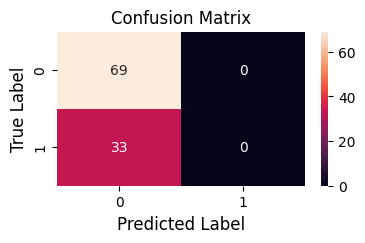


Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        69
           1       0.00      0.00      0.00        33

    accuracy                           0.68       102
   macro avg       0.34      0.50      0.40       102
weighted avg       0.46      0.68      0.55       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("theta","central","HAHV","svm")

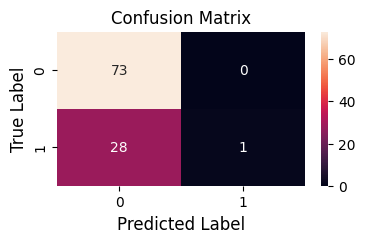


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        73
           1       1.00      0.03      0.07        29

    accuracy                           0.73       102
   macro avg       0.86      0.52      0.45       102
weighted avg       0.80      0.73      0.62       102



In [ ]:
print_conf("theta","central","LAHV","svm")

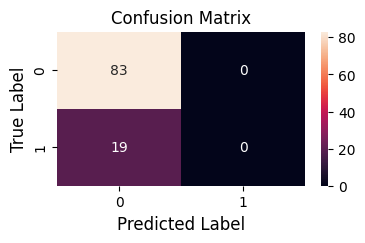


Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        83
           1       0.00      0.00      0.00        19

    accuracy                           0.81       102
   macro avg       0.41      0.50      0.45       102
weighted avg       0.66      0.81      0.73       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("theta","central","HALV","svm")

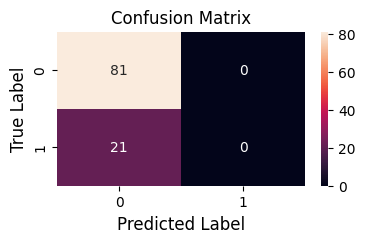


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89        81
           1       0.00      0.00      0.00        21

    accuracy                           0.79       102
   macro avg       0.40      0.50      0.44       102
weighted avg       0.63      0.79      0.70       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","central","LALV","svm")

In [ ]:
print_accuracy("HAHV","knn")

       frontal  central  parietal  occipital
theta    54.90    58.82     55.88      55.88
alpha    62.75    64.71     65.69      59.80
beta     58.82    61.76     69.61      60.78
gamma    67.65    63.73     63.73      62.75


In [ ]:
print_accuracy("LAHV","knn")

       frontal  central  parietal  occipital
theta    71.57    68.63     70.59      63.73
alpha    70.59    67.65     69.61      73.53
beta     66.67    64.71     69.61      66.67
gamma    72.55    70.59     66.67      70.59


In [ ]:
print_accuracy("HALV","knn")

       frontal  central  parietal  occipital
theta    79.41    76.47     77.45      82.35
alpha    84.31    73.53     75.49      74.51
beta     80.39    80.39     77.45      80.39
gamma    79.41    78.43     79.41      76.47


In [ ]:
print_accuracy("LALV","knn")

       frontal  central  parietal  occipital
theta    70.59    75.49     67.65      69.61
alpha    74.51    75.49     76.47      74.51
beta     76.47    76.47     79.41      70.59
gamma    72.55    72.55     77.45      70.59


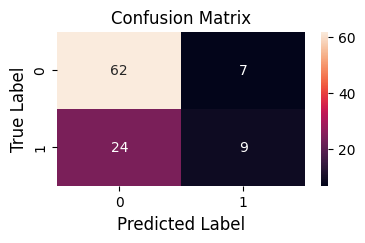


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        69
           1       0.56      0.27      0.37        33

    accuracy                           0.70       102
   macro avg       0.64      0.59      0.58       102
weighted avg       0.67      0.70      0.66       102



In [ ]:
print_conf("beta","parietal","HAHV","knn")

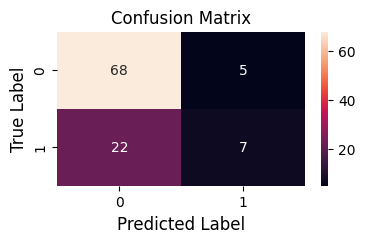


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83        73
           1       0.58      0.24      0.34        29

    accuracy                           0.74       102
   macro avg       0.67      0.59      0.59       102
weighted avg       0.71      0.74      0.69       102



In [ ]:
print_conf("alpha","occipital","LAHV","knn")

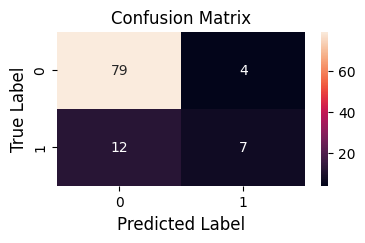


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        83
           1       0.64      0.37      0.47        19

    accuracy                           0.84       102
   macro avg       0.75      0.66      0.69       102
weighted avg       0.82      0.84      0.83       102



In [62]:
print_conf("alpha","frontal","HALV","knn")

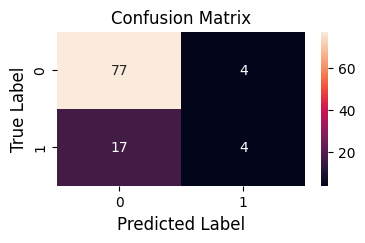


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        81
           1       0.50      0.19      0.28        21

    accuracy                           0.79       102
   macro avg       0.66      0.57      0.58       102
weighted avg       0.75      0.79      0.76       102



In [ ]:
print_conf("beta","parietal","LALV","knn")

In [ ]:
print_accuracy("HAHV","dtree")

       frontal  central  parietal  occipital
theta    61.76    60.78     58.82      56.86
alpha    53.92    62.75     57.84      62.75
beta     62.75    54.90     62.75      60.78
gamma    71.57    67.65     59.80      64.71


In [ ]:
print_accuracy("LAHV","dtree")

       frontal  central  parietal  occipital
theta    63.73    68.63     63.73      63.73
alpha    65.69    72.55     66.67      57.84
beta     55.88    63.73     57.84      57.84
gamma    58.82    74.51     61.76      64.71


In [ ]:
print_accuracy("HALV","dtree")

       frontal  central  parietal  occipital
theta    69.61    72.55     77.45      69.61
alpha    74.51    58.82     69.61      62.75
beta     77.45    71.57     78.43      68.63
gamma    77.45    80.39     74.51      73.53


In [ ]:
print_accuracy("LALV","dtree")

       frontal  central  parietal  occipital
theta    68.63    70.59     71.57      64.71
alpha    73.53    66.67     58.82      72.55
beta     65.69    66.67     71.57      71.57
gamma    71.57    70.59     70.59      62.75


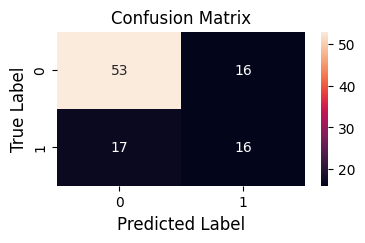


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76        69
           1       0.50      0.48      0.49        33

    accuracy                           0.68       102
   macro avg       0.63      0.63      0.63       102
weighted avg       0.67      0.68      0.68       102



In [ ]:
print_conf("gamma","frontal","HAHV","dtree")

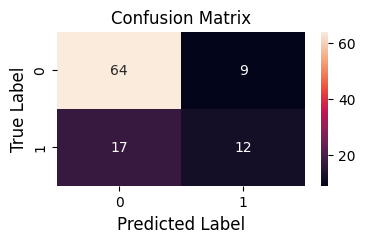


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        73
           1       0.57      0.41      0.48        29

    accuracy                           0.75       102
   macro avg       0.68      0.65      0.66       102
weighted avg       0.73      0.75      0.73       102



In [ ]:
print_conf("alpha","central","LAHV","dtree")

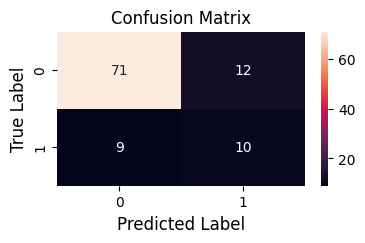


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        83
           1       0.45      0.53      0.49        19

    accuracy                           0.79       102
   macro avg       0.67      0.69      0.68       102
weighted avg       0.81      0.79      0.80       102



In [ ]:
print_conf("gamma","frontal","HALV","dtree")

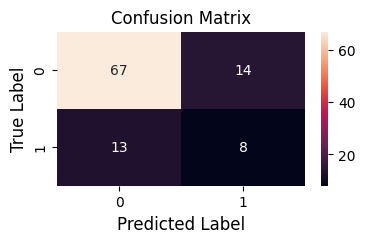


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        81
           1       0.36      0.38      0.37        21

    accuracy                           0.74       102
   macro avg       0.60      0.60      0.60       102
weighted avg       0.74      0.74      0.74       102



In [ ]:
print_conf("gamma","frontal","LALV","dtree")

In [ ]:
print_accuracy("HAHV","rf")

       frontal  central  parietal  occipital
theta    60.78    57.84     61.76      57.84
alpha    69.61    60.78     65.69      61.76
beta     62.75    64.71     64.71      64.71
gamma    65.69    64.71     73.53      68.63


In [60]:
print_accuracy("LAHV","rf")

       frontal  central  parietal  occipital
theta    70.59    70.59     67.65      68.63
alpha    71.57    73.53     75.49      70.59
beta     67.65    73.53     68.63      69.61
gamma    75.49    73.53     71.57      69.61


In [ ]:
print_accuracy("HALV","rf")

       frontal  central  parietal  occipital
theta    82.35    77.45     81.37      80.39
alpha    84.31    82.35     79.41      83.33
beta     79.41    77.45     86.27      79.41
gamma    80.39    79.41     83.33      79.41


In [ ]:
print_accuracy("LALV","rf")

       frontal  central  parietal  occipital
theta    77.45    75.49     78.43      73.53
alpha    77.45    79.41     77.45      75.49
beta     77.45    79.41     79.41      73.53
gamma    75.49    73.53     76.47      73.53


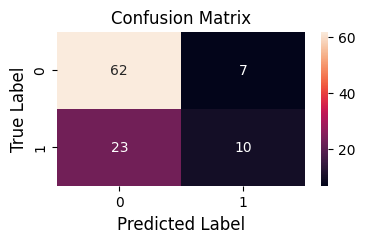


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81        69
           1       0.59      0.30      0.40        33

    accuracy                           0.71       102
   macro avg       0.66      0.60      0.60       102
weighted avg       0.68      0.71      0.67       102



In [53]:
print_conf("gamma","parietal","HAHV","rf")

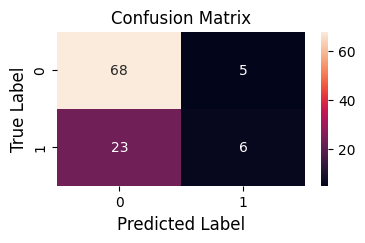


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83        73
           1       0.55      0.21      0.30        29

    accuracy                           0.73       102
   macro avg       0.65      0.57      0.56       102
weighted avg       0.69      0.73      0.68       102



In [61]:
print_conf("alpha","parietal","LAHV","rf")

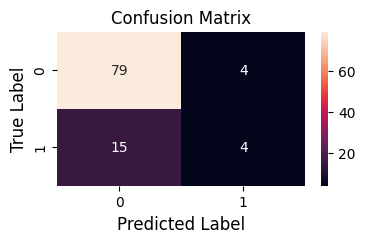


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        83
           1       0.50      0.21      0.30        19

    accuracy                           0.81       102
   macro avg       0.67      0.58      0.59       102
weighted avg       0.78      0.81      0.78       102



In [ ]:
print_conf("gamma","parietal","HALV","rf")

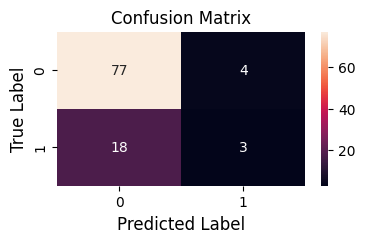


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87        81
           1       0.43      0.14      0.21        21

    accuracy                           0.78       102
   macro avg       0.62      0.55      0.54       102
weighted avg       0.73      0.78      0.74       102



In [ ]:
print_conf("alpha","parietal","LALV","rf")

In [ ]:
print_accuracy("HAHV","nb")

       frontal  central  parietal  occipital
theta    62.75    38.24     61.76      62.75
alpha    62.75    40.20     62.75      67.65
beta     62.75    39.22     67.65      67.65
gamma    67.65    40.20     67.65      67.65


In [ ]:
print_accuracy("LAHV","nb")

       frontal  central  parietal  occipital
theta    39.22    72.55     74.51      35.29
alpha    40.20    72.55     74.51      36.27
beta     36.27    73.53     73.53      33.33
gamma    32.35    73.53     72.55      28.43


In [ ]:
print_accuracy("HALV","nb")

       frontal  central  parietal  occipital
theta    80.39    28.43     80.39      80.39
alpha    80.39    27.45     78.43      80.39
beta     80.39    81.37     79.41      78.43
gamma    78.43    77.45     78.43      80.39


In [ ]:
print_accuracy("LALV","nb")

       frontal  central  parietal  occipital
theta    71.57    73.53     76.47      73.53
alpha    70.59    72.55     76.47      73.53
beta     71.57    70.59     53.92      75.49
gamma    77.45    76.47     79.41      77.45


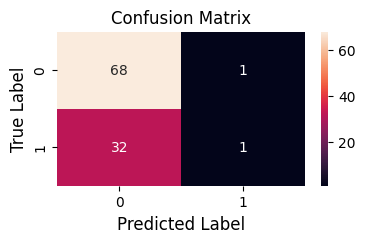


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.99      0.80        69
           1       0.50      0.03      0.06        33

    accuracy                           0.68       102
   macro avg       0.59      0.51      0.43       102
weighted avg       0.62      0.68      0.56       102



In [ ]:
print_conf("gamma","frontal","HAHV","nb")

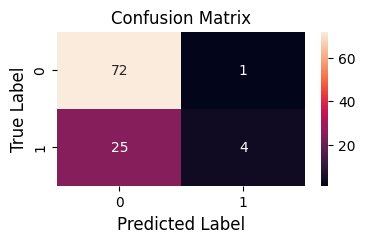


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85        73
           1       0.80      0.14      0.24        29

    accuracy                           0.75       102
   macro avg       0.77      0.56      0.54       102
weighted avg       0.76      0.75      0.67       102



In [ ]:
print_conf("alpha","parietal","LAHV","nb")

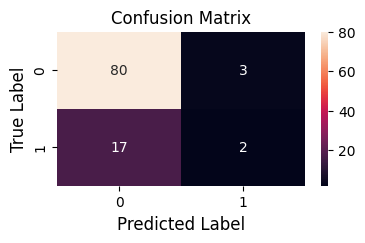


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        83
           1       0.40      0.11      0.17        19

    accuracy                           0.80       102
   macro avg       0.61      0.53      0.53       102
weighted avg       0.75      0.80      0.75       102



In [ ]:
print_conf("alpha","frontal","HALV","nb")

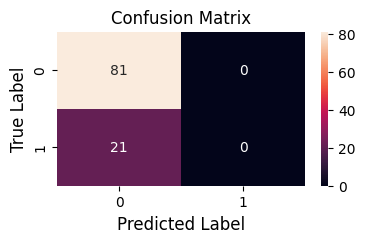


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89        81
           1       0.00      0.00      0.00        21

    accuracy                           0.79       102
   macro avg       0.40      0.50      0.44       102
weighted avg       0.63      0.79      0.70       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","parietal","LALV","nb")

In [ ]:
print_accuracy("HAHV","mlp")

       frontal  central  parietal  occipital
theta    67.65    67.65     67.65      67.65
alpha    67.65    66.67     67.65      67.65
beta     67.65    66.67     67.65      67.65
gamma    68.63    66.67     67.65      67.65


In [ ]:
print_accuracy("LAHV","mlp")

       frontal  central  parietal  occipital
theta    71.57    72.55     72.55      72.55
alpha    71.57    72.55     72.55      72.55
beta     71.57    72.55     72.55      72.55
gamma    71.57    70.59     71.57      71.57


In [ ]:
print_accuracy("HALV","mlp")

       frontal  central  parietal  occipital
theta    81.37    81.37     81.37      81.37
alpha    81.37    81.37     81.37      81.37
beta     81.37    82.35     81.37      81.37
gamma    81.37    80.39     80.39      81.37


In [ ]:
print_accuracy("LALV","mlp")

       frontal  central  parietal  occipital
theta    76.47    77.45     78.43      77.45
alpha    77.45    77.45     78.43      76.47
beta     77.45    77.45     79.41      77.45
gamma    79.41    79.41     79.41      79.41


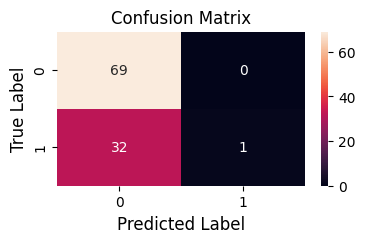


Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        69
           1       1.00      0.03      0.06        33

    accuracy                           0.69       102
   macro avg       0.84      0.52      0.44       102
weighted avg       0.79      0.69      0.57       102



In [ ]:
print_conf("gamma","frontal","HAHV","mlp")

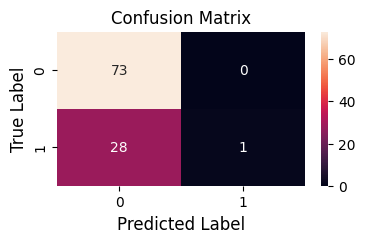


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        73
           1       1.00      0.03      0.07        29

    accuracy                           0.73       102
   macro avg       0.86      0.52      0.45       102
weighted avg       0.80      0.73      0.62       102



In [ ]:
print_conf("alpha","central","LAHV","mlp")

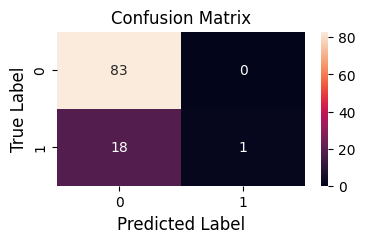


Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        83
           1       1.00      0.05      0.10        19

    accuracy                           0.82       102
   macro avg       0.91      0.53      0.50       102
weighted avg       0.85      0.82      0.75       102



In [ ]:
print_conf("beta","central","HALV","mlp")

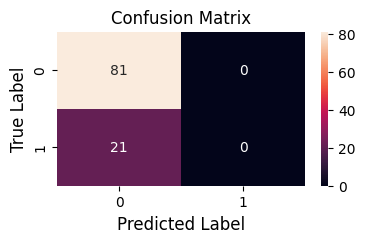


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.89        81
           1       0.00      0.00      0.00        21

    accuracy                           0.79       102
   macro avg       0.40      0.50      0.44       102
weighted avg       0.63      0.79      0.70       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","parietal","LALV","mlp")

In [ ]:
print_accuracy("HAHV","ab")

       frontal  central  parietal  occipital
theta    64.71    62.75     65.69      63.73
alpha    63.73    67.65     63.73      67.65
beta     65.69    68.63     68.63      67.65
gamma    66.67    63.73     65.69      66.67


In [ ]:
print_accuracy("LAHV","ab")

       frontal  central  parietal  occipital
theta    70.59    72.55     71.57      68.63
alpha    71.57    74.51     71.57      71.57
beta     70.59    73.53     73.53      73.53
gamma    72.55    73.53     72.55      70.59


In [ ]:
print_accuracy("HALV","ab")

       frontal  central  parietal  occipital
theta    82.35    79.41     81.37      76.47
alpha    79.41    81.37     77.45      79.41
beta     78.43    79.41     81.37      79.41
gamma    78.43    78.43     79.41      77.45


In [ ]:
print_accuracy("LALV","ab")

       frontal  central  parietal  occipital
theta    75.49    77.45     77.45      77.45
alpha    75.49    76.47     77.45      77.45
beta     73.53    77.45     81.37      77.45
gamma    77.45    75.49     77.45      74.51


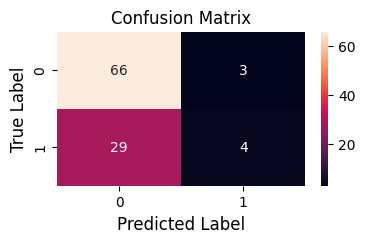


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80        69
           1       0.57      0.12      0.20        33

    accuracy                           0.69       102
   macro avg       0.63      0.54      0.50       102
weighted avg       0.65      0.69      0.61       102



In [ ]:
print_conf("beta","central","HAHV","ab")

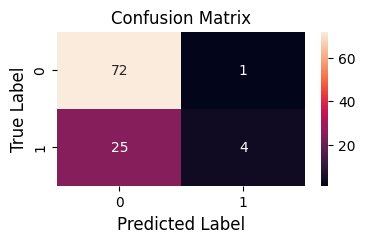


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85        73
           1       0.80      0.14      0.24        29

    accuracy                           0.75       102
   macro avg       0.77      0.56      0.54       102
weighted avg       0.76      0.75      0.67       102



In [ ]:
print_conf("alpha","central","LAHV","ab")

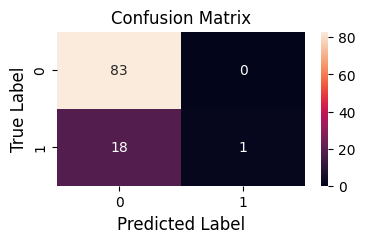


Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        83
           1       1.00      0.05      0.10        19

    accuracy                           0.82       102
   macro avg       0.91      0.53      0.50       102
weighted avg       0.85      0.82      0.75       102



In [ ]:
print_conf("theta","frontal","HALV","ab")

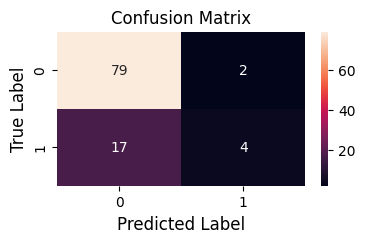


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89        81
           1       0.67      0.19      0.30        21

    accuracy                           0.81       102
   macro avg       0.74      0.58      0.59       102
weighted avg       0.79      0.81      0.77       102



In [ ]:
print_conf("beta","parietal","LALV","ab")

In [ ]:
print_accuracy("HAHV","xgb")

       frontal  central  parietal  occipital
theta    58.82    66.67     65.69      62.75
alpha    67.65    66.67     69.61      65.69
beta     71.57    63.73     69.61      64.71
gamma    70.59    62.75     71.57      70.59


In [ ]:
print_accuracy("LAHV","xgb")

       frontal  central  parietal  occipital
theta    72.55    71.57     69.61      70.59
alpha    71.57    72.55     74.51      72.55
beta     75.49    74.51     73.53      74.51
gamma    73.53    71.57     72.55      73.53


In [ ]:
print_accuracy("HALV","xgb")

       frontal  central  parietal  occipital
theta    80.39    81.37     80.39      80.39
alpha    82.35    81.37     78.43      79.41
beta     82.35    80.39     80.39      81.37
gamma    80.39    79.41     82.35      77.45


In [ ]:
print_accuracy("LALV","xgb")

       frontal  central  parietal  occipital
theta    75.49    77.45     76.47      78.43
alpha    76.47    77.45     77.45      77.45
beta     78.43    78.43     80.39      78.43
gamma    76.47    78.43     76.47      76.47


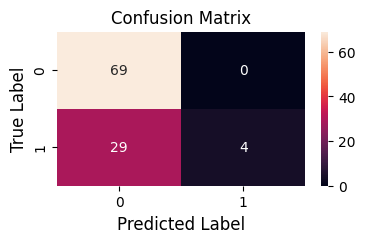


Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        69
           1       1.00      0.12      0.22        33

    accuracy                           0.72       102
   macro avg       0.85      0.56      0.52       102
weighted avg       0.80      0.72      0.63       102



In [ ]:
print_conf("beta","frontal","HAHV","xgb")

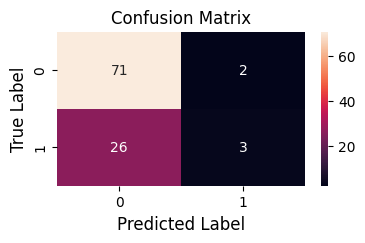


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.97      0.84        73
           1       0.60      0.10      0.18        29

    accuracy                           0.73       102
   macro avg       0.67      0.54      0.51       102
weighted avg       0.69      0.73      0.65       102



In [ ]:
print_conf("alpha","occipital","LAHV","xgb")

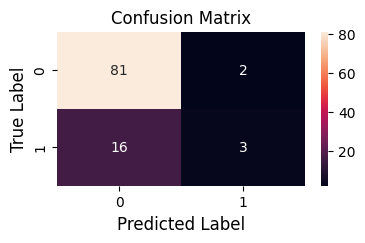


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        83
           1       0.60      0.16      0.25        19

    accuracy                           0.82       102
   macro avg       0.72      0.57      0.57       102
weighted avg       0.79      0.82      0.78       102



In [ ]:
print_conf("alpha","frontal","HALV","xgb")

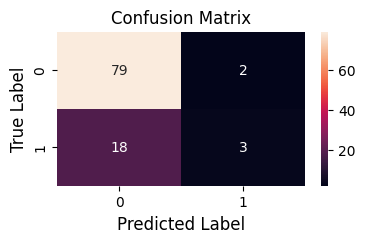


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89        81
           1       0.60      0.14      0.23        21

    accuracy                           0.80       102
   macro avg       0.71      0.56      0.56       102
weighted avg       0.77      0.80      0.75       102



In [ ]:
print_conf("beta","parietal","LALV","xgb")

In [ ]:
print_accuracy("HAHV","lgbm")

[LightGBM] [Info] Number of positive: 248, number of negative: 674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268980 -> initscore=-0.999801
[LightGBM] [Info] Start training from score -0.999801
[LightGBM] [Info] Number of positive: 248, number of negative: 674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268980 -> initscore=-0.999801
[LightGBM] [Info] Start training from score -0.999801
[LightGBM] [Info] Number o

In [ ]:
print_accuracy("LAHV","lgbm")

[LightGBM] [Info] Number of positive: 230, number of negative: 692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249458 -> initscore=-1.101507
[LightGBM] [Info] Start training from score -1.101507
[LightGBM] [Info] Number of positive: 230, number of negative: 692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249458 -> initscore=-1.101507
[LightGBM] [Info] Start training from score -1.101507
[LightGBM] [Info] Number o

In [ ]:
print_accuracy("HALV","lgbm")

[LightGBM] [Info] Number of positive: 210, number of negative: 712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227766 -> initscore=-1.220970
[LightGBM] [Info] Start training from score -1.220970
[LightGBM] [Info] Number of positive: 210, number of negative: 712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227766 -> initscore=-1.220970
[LightGBM] [Info] Start training from score -1.220970
[LightGBM] [Info] Number o

In [ ]:
print_accuracy("LALV","lgbm")

[LightGBM] [Info] Number of positive: 234, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253796 -> initscore=-1.078468
[LightGBM] [Info] Start training from score -1.078468
[LightGBM] [Info] Number of positive: 234, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253796 -> initscore=-1.078468
[LightGBM] [Info] Start training from score -1.078468
[LightGBM] [Info] Number o

[LightGBM] [Info] Number of positive: 248, number of negative: 674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268980 -> initscore=-0.999801
[LightGBM] [Info] Start training from score -0.999801


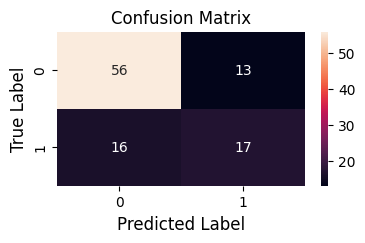


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        69
           1       0.57      0.52      0.54        33

    accuracy                           0.72       102
   macro avg       0.67      0.66      0.67       102
weighted avg       0.71      0.72      0.71       102



In [ ]:
print_conf("gamma","frontal","HAHV","lgbm")

[LightGBM] [Info] Number of positive: 230, number of negative: 692
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.249458 -> initscore=-1.101507
[LightGBM] [Info] Start training from score -1.101507


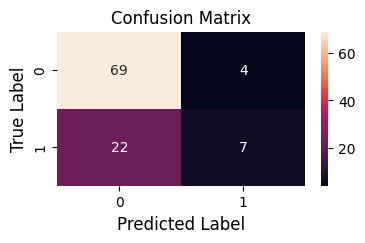


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84        73
           1       0.64      0.24      0.35        29

    accuracy                           0.75       102
   macro avg       0.70      0.59      0.60       102
weighted avg       0.72      0.75      0.70       102



In [ ]:
print_conf("gamma","central","LAHV","lgbm")

[LightGBM] [Info] Number of positive: 210, number of negative: 712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227766 -> initscore=-1.220970
[LightGBM] [Info] Start training from score -1.220970
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


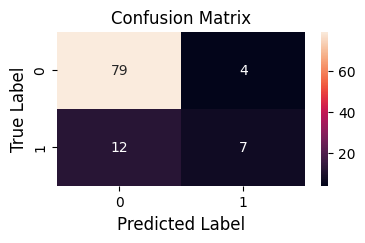


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        83
           1       0.64      0.37      0.47        19

    accuracy                           0.84       102
   macro avg       0.75      0.66      0.69       102
weighted avg       0.82      0.84      0.83       102



In [ ]:
print_conf("gamma","frontal","HALV","lgbm")

[LightGBM] [Info] Number of positive: 234, number of negative: 688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 922, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.253796 -> initscore=-1.078468
[LightGBM] [Info] Start training from score -1.078468


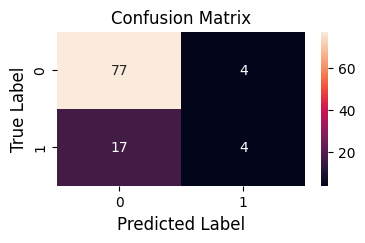


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        81
           1       0.50      0.19      0.28        21

    accuracy                           0.79       102
   macro avg       0.66      0.57      0.58       102
weighted avg       0.75      0.79      0.76       102



In [ ]:
print_conf("alpha","parietal","LALV","lgbm")

In [ ]:
print_accuracy("HAHV","gpc")

       frontal  central  parietal  occipital
theta    67.65    67.65     67.65      67.65
alpha    67.65    67.65     67.65      67.65
beta     67.65    67.65     67.65      67.65
gamma    67.65    67.65     67.65      65.69


In [ ]:
print_accuracy("LAHV","gpc")

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


       frontal  central  parietal  occipital
theta    71.57    71.57     71.57      72.55
alpha    71.57    71.57     71.57      72.55
beta     71.57    71.57     71.57      72.55
gamma    71.57    71.57     71.57      71.57


In [ ]:
print_accuracy("HALV","gpc")

       frontal  central  parietal  occipital
theta    81.37    81.37     81.37      81.37
alpha    81.37    81.37     81.37      81.37
beta     81.37    81.37     81.37      82.35
gamma    81.37    80.39     81.37      81.37


In [ ]:
print_accuracy("LALV","gpc")

       frontal  central  parietal  occipital
theta    78.43    79.41     79.41      78.43
alpha    78.43    79.41     79.41      78.43
beta     79.41    79.41     79.41      78.43
gamma    79.41    79.41     78.43      77.45


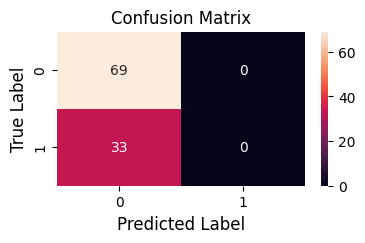


Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        69
           1       0.00      0.00      0.00        33

    accuracy                           0.68       102
   macro avg       0.34      0.50      0.40       102
weighted avg       0.46      0.68      0.55       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HAHV","gpc")

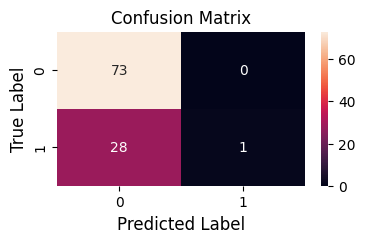


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        73
           1       1.00      0.03      0.07        29

    accuracy                           0.73       102
   macro avg       0.86      0.52      0.45       102
weighted avg       0.80      0.73      0.62       102



In [ ]:
print_conf("alpha","occipital","LAHV","gpc")

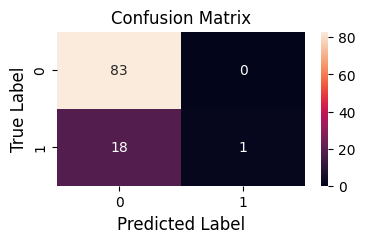


Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        83
           1       1.00      0.05      0.10        19

    accuracy                           0.82       102
   macro avg       0.91      0.53      0.50       102
weighted avg       0.85      0.82      0.75       102



In [ ]:
print_conf("beta","occipital","HALV","gpc")

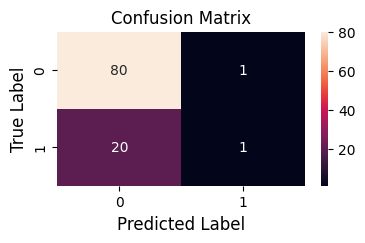


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88        81
           1       0.50      0.05      0.09        21

    accuracy                           0.79       102
   macro avg       0.65      0.52      0.49       102
weighted avg       0.74      0.79      0.72       102



In [ ]:
print_conf("beta","parietal","LALV","gpc")

In [ ]:
print_accuracy("HAHV","per")

       frontal  central  parietal  occipital
theta    55.88    57.84     59.80      59.80
alpha    40.20    57.84     56.86      48.04
beta     62.75    53.92     50.00      62.75
gamma    58.82    57.84     39.22      61.76


In [ ]:
print_accuracy("LAHV","per")

       frontal  central  parietal  occipital
theta    65.69    38.24     56.86      31.37
alpha    36.27    38.24     57.84      49.02
beta     64.71    43.14     58.82      32.35
gamma    63.73    37.25     44.12      71.57


In [ ]:
print_accuracy("HALV","per")

       frontal  central  parietal  occipital
theta    79.41    73.53     70.59      76.47
alpha    74.51    78.43     74.51      53.92
beta     81.37    51.96     68.63      74.51
gamma    81.37    81.37     70.59      78.43


In [ ]:
print_accuracy("LALV","per")

       frontal  central  parietal  occipital
theta    61.76    53.92     70.59      42.16
alpha    67.65    70.59     72.55      36.27
beta     47.06    68.63     56.86      69.61
gamma    66.67    53.92     31.37      62.75


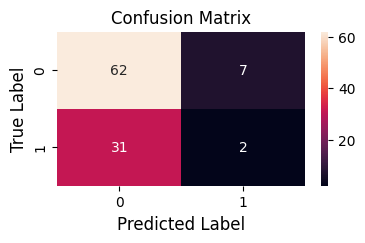


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        69
           1       0.22      0.06      0.10        33

    accuracy                           0.63       102
   macro avg       0.44      0.48      0.43       102
weighted avg       0.52      0.63      0.55       102



In [ ]:
print_conf("beta","frontal","HAHV","per")

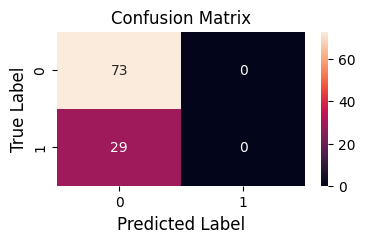


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83        73
           1       0.00      0.00      0.00        29

    accuracy                           0.72       102
   macro avg       0.36      0.50      0.42       102
weighted avg       0.51      0.72      0.60       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","occipital","LAHV","per")

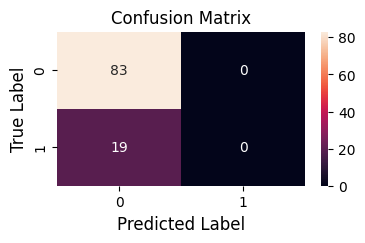


Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        83
           1       0.00      0.00      0.00        19

    accuracy                           0.81       102
   macro avg       0.41      0.50      0.45       102
weighted avg       0.66      0.81      0.73       102



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HALV","per")

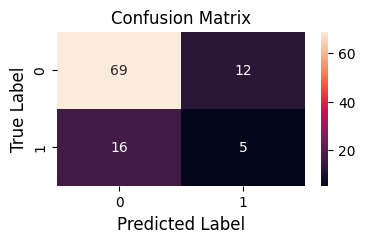


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        81
           1       0.29      0.24      0.26        21

    accuracy                           0.73       102
   macro avg       0.55      0.54      0.55       102
weighted avg       0.71      0.73      0.71       102



In [ ]:
print_conf("alpha","parietal","LALV","per")

In [ ]:
print_accuracy("HAHV","cb")

       frontal  central  parietal  occipital
theta    62.75    66.67     58.82      56.86
alpha    65.69    67.65     63.73      62.75
beta     66.67    65.69     61.76      59.80
gamma    64.71    60.78     71.57      71.57


In [ ]:
print_accuracy("LAHV","cb")

       frontal  central  parietal  occipital
theta    72.55    70.59     65.69      68.63
alpha    66.67    72.55     68.63      69.61
beta     64.71    69.61     64.71      68.63
gamma    65.69    77.45     68.63      64.71


In [ ]:
print_accuracy("HALV","cb")

       frontal  central  parietal  occipital
theta    79.41    78.43     77.45      77.45
alpha    78.43    79.41     76.47      74.51
beta     82.35    74.51     80.39      78.43
gamma    78.43    80.39     83.33      77.45


In [ ]:
print_accuracy("LALV","cb")

       frontal  central  parietal  occipital
theta    70.59    71.57     72.55      68.63
alpha    73.53    76.47     80.39      80.39
beta     72.55    75.49     75.49      73.53
gamma    71.57    73.53     74.51      70.59


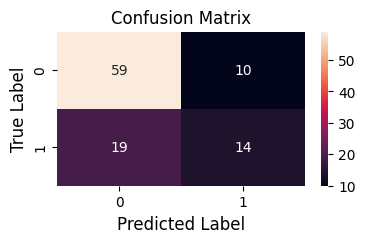


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.80        69
           1       0.58      0.42      0.49        33

    accuracy                           0.72       102
   macro avg       0.67      0.64      0.65       102
weighted avg       0.70      0.72      0.70       102



In [ ]:
print_conf("gamma","parietal","HAHV","cb")

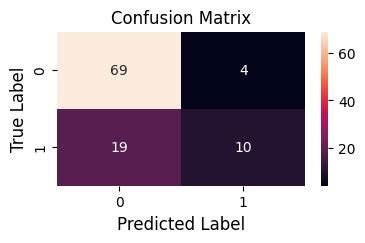


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86        73
           1       0.71      0.34      0.47        29

    accuracy                           0.77       102
   macro avg       0.75      0.65      0.66       102
weighted avg       0.76      0.77      0.75       102



In [ ]:
print_conf("gamma","central","LAHV","cb")

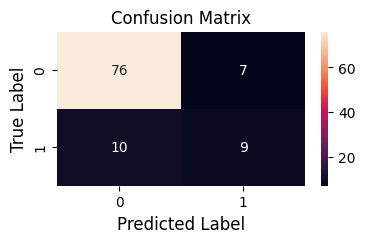


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        83
           1       0.56      0.47      0.51        19

    accuracy                           0.83       102
   macro avg       0.72      0.69      0.71       102
weighted avg       0.82      0.83      0.83       102



In [ ]:
print_conf("gamma","parietal","HALV","cb")

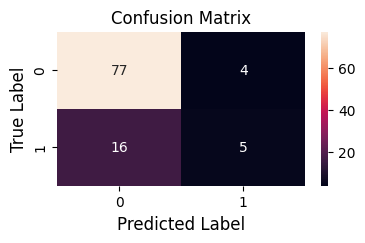


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        81
           1       0.56      0.24      0.33        21

    accuracy                           0.80       102
   macro avg       0.69      0.59      0.61       102
weighted avg       0.77      0.80      0.77       102



In [ ]:
print_conf("alpha","parietal","LALV","cb")

In [ ]:
print_accuracy("HAHV","cnn")

Epoch 1/20
32/32 [==============================] - 2s 13ms/step - loss: 0.7575 - accuracy: 0.6357 - val_loss: 0.7125 - val_accuracy: 0.6992
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6748 - accuracy: 0.6758 - val_loss: 0.6315 - val_accuracy: 0.6992
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6943 - val_loss: 0.6182 - val_accuracy: 0.6992
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6612 - accuracy: 0.6904 - val_loss: 0.6162 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.7217 - val_loss: 0.6214 - val_accuracy: 0.6992
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6501 - accuracy: 0.7012 - val_loss: 0.6086 - val_accuracy: 0.6992
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6005 - accuracy: 0.7246 - val_loss: 0.6180 - val_accuracy: 0.6992
Epoch 8/20
32/32 [=

In [ ]:
print_accuracy("LAHV","cnn")

Epoch 1/20
32/32 [==============================] - 2s 12ms/step - loss: 0.7228 - accuracy: 0.6631 - val_loss: 0.8717 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6198 - accuracy: 0.7324 - val_loss: 0.7168 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6108 - accuracy: 0.7178 - val_loss: 0.6817 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5963 - accuracy: 0.7314 - val_loss: 0.6981 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6228 - accuracy: 0.7334 - val_loss: 0.6084 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6028 - accuracy: 0.7334 - val_loss: 0.5892 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6195 - accuracy: 0.7373 - val_loss: 0.6056 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

In [ ]:
# print_accuracy("HALV","cnn")

In [ ]:
print_accuracy("LALV","cnn")

Epoch 1/20
32/32 [==============================] - 2s 13ms/step - loss: 0.6602 - accuracy: 0.6875 - val_loss: 0.6635 - val_accuracy: 0.6484
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6388 - accuracy: 0.7158 - val_loss: 0.6104 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6114 - accuracy: 0.7168 - val_loss: 0.5939 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.7217 - val_loss: 0.5930 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.7461 - val_loss: 0.6074 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6081 - accuracy: 0.7285 - val_loss: 0.5863 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6074 - accuracy: 0.7422 - val_loss: 0.5870 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

Epoch 1/20
32/32 [==============================] - 2s 12ms/step - loss: 0.7384 - accuracy: 0.6836 - val_loss: 0.6953 - val_accuracy: 0.6250
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.7416 - accuracy: 0.6865 - val_loss: 0.6671 - val_accuracy: 0.6250
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.6973 - val_loss: 0.6569 - val_accuracy: 0.6562
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6785 - accuracy: 0.7061 - val_loss: 0.6449 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.7070 - val_loss: 0.6461 - val_accuracy: 0.6680
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6541 - accuracy: 0.7031 - val_loss: 0.6373 - val_accuracy: 0.6992
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.7119 - val_loss: 0.6277 - val_accuracy: 0.6992
Epoch 8/20
32/32 [=

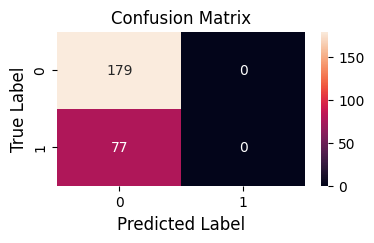


Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       179
           1       0.00      0.00      0.00        77

    accuracy                           0.70       256
   macro avg       0.35      0.50      0.41       256
weighted avg       0.49      0.70      0.58       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HAHV","cnn")

Epoch 1/20
32/32 [==============================] - 3s 17ms/step - loss: 0.6698 - accuracy: 0.7100 - val_loss: 0.7813 - val_accuracy: 0.4727
Epoch 2/20
32/32 [==============================] - 0s 7ms/step - loss: 0.6169 - accuracy: 0.7324 - val_loss: 0.7871 - val_accuracy: 0.5938
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6310 - accuracy: 0.7158 - val_loss: 0.6481 - val_accuracy: 0.6250
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6191 - accuracy: 0.7207 - val_loss: 0.6126 - val_accuracy: 0.7422
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.6074 - accuracy: 0.7266 - val_loss: 0.6322 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 10ms/step - loss: 0.6024 - accuracy: 0.7422 - val_loss: 0.5965 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5993 - accuracy: 0.7275 - val_loss: 0.5931 - val_accuracy: 0.7539
Epoch 8/20
32/32 [

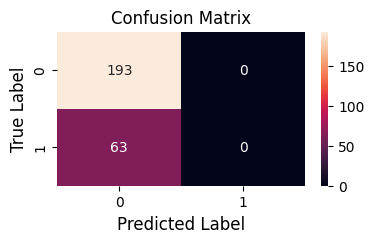


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       193
           1       0.00      0.00      0.00        63

    accuracy                           0.75       256
   macro avg       0.38      0.50      0.43       256
weighted avg       0.57      0.75      0.65       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("alpha","parietal","LAHV","cnn")

Epoch 1/20
32/32 [==============================] - 2s 13ms/step - loss: 0.6477 - accuracy: 0.7324 - val_loss: 0.6807 - val_accuracy: 0.6836
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6284 - accuracy: 0.7627 - val_loss: 0.6416 - val_accuracy: 0.7461
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5973 - accuracy: 0.7598 - val_loss: 0.5738 - val_accuracy: 0.7930
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5853 - accuracy: 0.7617 - val_loss: 0.5700 - val_accuracy: 0.7930
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5653 - accuracy: 0.7773 - val_loss: 0.5677 - val_accuracy: 0.7930
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5893 - accuracy: 0.7637 - val_loss: 0.5526 - val_accuracy: 0.7930
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5560 - accuracy: 0.7705 - val_loss: 0.5403 - val_accuracy: 0.7930
Epoch 8/20
32/32 [=

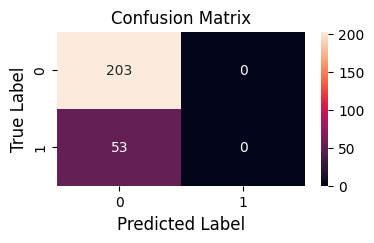


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       203
           1       0.00      0.00      0.00        53

    accuracy                           0.79       256
   macro avg       0.40      0.50      0.44       256
weighted avg       0.63      0.79      0.70       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HALV","cnn")

Epoch 1/20
32/32 [==============================] - 4s 13ms/step - loss: 0.6705 - accuracy: 0.6816 - val_loss: 0.6311 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6545 - accuracy: 0.7119 - val_loss: 0.6229 - val_accuracy: 0.7266
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6171 - accuracy: 0.7402 - val_loss: 0.5856 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6268 - accuracy: 0.7295 - val_loss: 0.5772 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6039 - accuracy: 0.7334 - val_loss: 0.5738 - val_accuracy: 0.7461
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5777 - accuracy: 0.7432 - val_loss: 0.5719 - val_accuracy: 0.7461
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5928 - accuracy: 0.7334 - val_loss: 0.5708 - val_accuracy: 0.7500
Epoch 8/20
32/32 [=

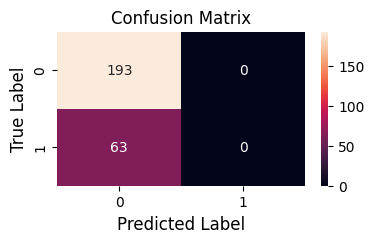


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       193
           1       0.00      0.00      0.00        63

    accuracy                           0.75       256
   macro avg       0.38      0.50      0.43       256
weighted avg       0.57      0.75      0.65       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","LALV","cnn")

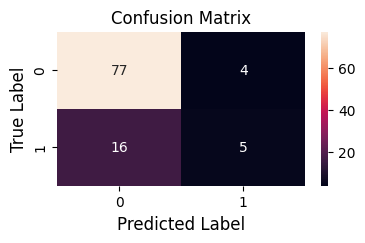


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        81
           1       0.56      0.24      0.33        21

    accuracy                           0.80       102
   macro avg       0.69      0.59      0.61       102
weighted avg       0.77      0.80      0.77       102



In [ ]:
print_conf("alpha","parietal","LALV","cb")

In [ ]:
print_accuracy("HAHV","ann")

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.6314 - accuracy: 0.6992 - val_loss: 0.6131 - val_accuracy: 0.6992
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5929 - accuracy: 0.7256 - val_loss: 0.6175 - val_accuracy: 0.6992
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5936 - accuracy: 0.7256 - val_loss: 0.6128 - val_accuracy: 0.6992
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5926 - accuracy: 0.7256 - val_loss: 0.6116 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5906 - accuracy: 0.7256 - val_loss: 0.6126 - val_accuracy: 0.6992
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5893 - accuracy: 0.7256 - val_loss: 0.6130 - val_accuracy: 0.6992
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5879 - accuracy: 0.7246 - val_loss: 0.6131 - val_accuracy: 0.6992
Epoch 8/20
32/32 [==

In [ ]:
print_accuracy("LAHV","ann")

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.6460 - accuracy: 0.6318 - val_loss: 0.6381 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5655 - accuracy: 0.7471 - val_loss: 0.6071 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5611 - accuracy: 0.7471 - val_loss: 0.5887 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5608 - accuracy: 0.7471 - val_loss: 0.5935 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5594 - accuracy: 0.7471 - val_loss: 0.5969 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5588 - accuracy: 0.7471 - val_loss: 0.5860 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5574 - accuracy: 0.7471 - val_loss: 0.6060 - val_accuracy: 0.7539
Epoch 8/20
32/32 [==

In [ ]:
# print_accuracy("HALV","ann")

In [ ]:
print_accuracy("LALV","ann")

Epoch 1/20
32/32 [==============================] - 1s 13ms/step - loss: 0.6127 - accuracy: 0.7510 - val_loss: 0.5647 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5640 - accuracy: 0.7510 - val_loss: 0.5556 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5599 - accuracy: 0.7510 - val_loss: 0.5525 - val_accuracy: 0.7500
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5577 - accuracy: 0.7480 - val_loss: 0.5475 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5557 - accuracy: 0.7510 - val_loss: 0.5521 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5557 - accuracy: 0.7510 - val_loss: 0.5537 - val_accuracy: 0.7617
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5537 - accuracy: 0.7480 - val_loss: 0.5538 - val_accuracy: 0.7500
Epoch 8/20
32/32 [=

Epoch 1/20
32/32 [==============================] - 1s 8ms/step - loss: 0.6341 - accuracy: 0.6963 - val_loss: 0.6163 - val_accuracy: 0.6953
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5877 - accuracy: 0.7227 - val_loss: 0.6112 - val_accuracy: 0.6992
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5839 - accuracy: 0.7256 - val_loss: 0.6102 - val_accuracy: 0.6992
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5839 - accuracy: 0.7256 - val_loss: 0.6185 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5797 - accuracy: 0.7256 - val_loss: 0.6105 - val_accuracy: 0.6992
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5809 - accuracy: 0.7285 - val_loss: 0.6098 - val_accuracy: 0.7031
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5808 - accuracy: 0.7207 - val_loss: 0.6360 - val_accuracy: 0.6992
Epoch 8/20
32/32 [==

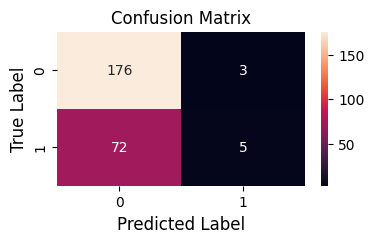


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       179
           1       0.62      0.06      0.12        77

    accuracy                           0.71       256
   macro avg       0.67      0.52      0.47       256
weighted avg       0.68      0.71      0.61       256



In [ ]:
print_conf("gamma","parietal","HAHV","ann")

Epoch 1/20
32/32 [==============================] - 1s 8ms/step - loss: 0.6061 - accuracy: 0.7197 - val_loss: 0.6134 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5685 - accuracy: 0.7471 - val_loss: 0.5923 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5643 - accuracy: 0.7471 - val_loss: 0.5937 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5627 - accuracy: 0.7471 - val_loss: 0.5901 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5604 - accuracy: 0.7471 - val_loss: 0.5972 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5593 - accuracy: 0.7471 - val_loss: 0.5955 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5586 - accuracy: 0.7471 - val_loss: 0.5996 - val_accuracy: 0.7539
Epoch 8/20
32/32 [==

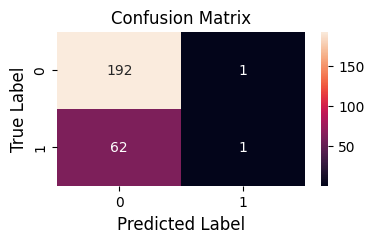


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       193
           1       0.50      0.02      0.03        63

    accuracy                           0.75       256
   macro avg       0.63      0.51      0.44       256
weighted avg       0.69      0.75      0.66       256



In [ ]:
print_conf("alpha","frontal","LAHV","ann")

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.6067 - accuracy: 0.7490 - val_loss: 0.5389 - val_accuracy: 0.7930
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7764 - val_loss: 0.5261 - val_accuracy: 0.7930
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5292 - accuracy: 0.7764 - val_loss: 0.5214 - val_accuracy: 0.7930
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5236 - accuracy: 0.7764 - val_loss: 0.5176 - val_accuracy: 0.7930
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5204 - accuracy: 0.7764 - val_loss: 0.5226 - val_accuracy: 0.7852
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5201 - accuracy: 0.7764 - val_loss: 0.5142 - val_accuracy: 0.7930
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5213 - accuracy: 0.7773 - val_loss: 0.5141 - val_accuracy: 0.7930
Epoch 8/20
32/32 [==

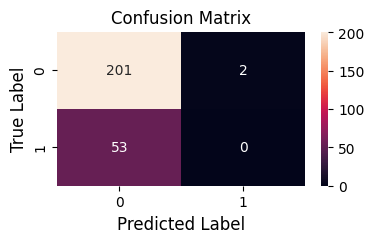


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       203
           1       0.00      0.00      0.00        53

    accuracy                           0.79       256
   macro avg       0.40      0.50      0.44       256
weighted avg       0.63      0.79      0.70       256



In [ ]:
print_conf("gamma","central","HALV","ann")

Epoch 1/20
32/32 [==============================] - 1s 9ms/step - loss: 0.6210 - accuracy: 0.7314 - val_loss: 0.5894 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.7510 - val_loss: 0.5781 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5570 - accuracy: 0.7520 - val_loss: 0.5751 - val_accuracy: 0.7617
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5541 - accuracy: 0.7490 - val_loss: 0.5781 - val_accuracy: 0.7617
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.5532 - accuracy: 0.7500 - val_loss: 0.5798 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5507 - accuracy: 0.7510 - val_loss: 0.5723 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5539 - accuracy: 0.7490 - val_loss: 0.5736 - val_accuracy: 0.7578
Epoch 8/20
32/32 [==

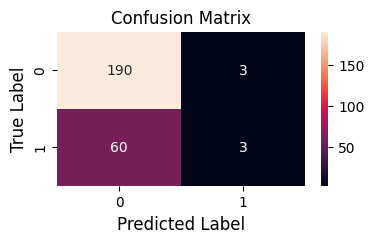


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       193
           1       0.50      0.05      0.09        63

    accuracy                           0.75       256
   macro avg       0.63      0.52      0.47       256
weighted avg       0.70      0.75      0.67       256



In [ ]:
print_conf("beta","central","LALV","ann")

In [ ]:
print_accuracy("HAHV","lstm")

Epoch 1/20
32/32 [==============================] - 4s 37ms/step - loss: 0.6640 - accuracy: 0.6484 - val_loss: 0.6140 - val_accuracy: 0.6992
Epoch 2/20
32/32 [==============================] - 0s 10ms/step - loss: 0.6472 - accuracy: 0.6865 - val_loss: 0.6127 - val_accuracy: 0.6992
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 0.6309 - accuracy: 0.7119 - val_loss: 0.6143 - val_accuracy: 0.6992
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6093 - accuracy: 0.7119 - val_loss: 0.6146 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6116 - accuracy: 0.7148 - val_loss: 0.6151 - val_accuracy: 0.6992
Epoch 6/20
32/32 [==============================] - 0s 7ms/step - loss: 0.6194 - accuracy: 0.7139 - val_loss: 0.6163 - val_accuracy: 0.6992
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6041 - accuracy: 0.7197 - val_loss: 0.6173 - val_accuracy: 0.6992
Epoch 8/20
32/32 [

In [ ]:
print_accuracy("LAHV","lstm")

Epoch 1/20
32/32 [==============================] - 3s 31ms/step - loss: 0.6463 - accuracy: 0.6191 - val_loss: 0.5694 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5957 - accuracy: 0.7393 - val_loss: 0.5643 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5915 - accuracy: 0.7402 - val_loss: 0.5664 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.5871 - accuracy: 0.7451 - val_loss: 0.5655 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5859 - accuracy: 0.7441 - val_loss: 0.5691 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5763 - accuracy: 0.7480 - val_loss: 0.5708 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5759 - accuracy: 0.7461 - val_loss: 0.5691 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

In [ ]:
print_accuracy("HALV","lstm")

Epoch 1/20
32/32 [==============================] - 4s 35ms/step - loss: 0.6304 - accuracy: 0.6865 - val_loss: 0.5262 - val_accuracy: 0.7930
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5649 - accuracy: 0.7715 - val_loss: 0.5141 - val_accuracy: 0.7930
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5528 - accuracy: 0.7725 - val_loss: 0.5119 - val_accuracy: 0.7930
Epoch 4/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5548 - accuracy: 0.7744 - val_loss: 0.5124 - val_accuracy: 0.7930
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5487 - accuracy: 0.7764 - val_loss: 0.5145 - val_accuracy: 0.7930
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5547 - accuracy: 0.7764 - val_loss: 0.5137 - val_accuracy: 0.7930
Epoch 7/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5391 - accuracy: 0.7764 - val_loss: 0.5077 - val_accuracy: 0.7930
Epoch 8/20
32/32 [=

In [ ]:
print_accuracy("LALV","lstm")

Epoch 1/20
32/32 [==============================] - 3s 24ms/step - loss: 0.6143 - accuracy: 0.7100 - val_loss: 0.5599 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6075 - accuracy: 0.7275 - val_loss: 0.5634 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5942 - accuracy: 0.7373 - val_loss: 0.5599 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6020 - accuracy: 0.7314 - val_loss: 0.5662 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5837 - accuracy: 0.7520 - val_loss: 0.5659 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5834 - accuracy: 0.7471 - val_loss: 0.5621 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5831 - accuracy: 0.7539 - val_loss: 0.5674 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

Epoch 1/20
32/32 [==============================] - 3s 22ms/step - loss: 0.6436 - accuracy: 0.6543 - val_loss: 0.6143 - val_accuracy: 0.6992
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6073 - accuracy: 0.7246 - val_loss: 0.6153 - val_accuracy: 0.6992
Epoch 3/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6022 - accuracy: 0.7295 - val_loss: 0.6154 - val_accuracy: 0.6992
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.6037 - accuracy: 0.7158 - val_loss: 0.6155 - val_accuracy: 0.6992
Epoch 5/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5946 - accuracy: 0.7266 - val_loss: 0.6149 - val_accuracy: 0.6992
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5976 - accuracy: 0.7256 - val_loss: 0.6139 - val_accuracy: 0.6992
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5945 - accuracy: 0.7266 - val_loss: 0.6139 - val_accuracy: 0.6992
Epoch 8/20
32/32 [=

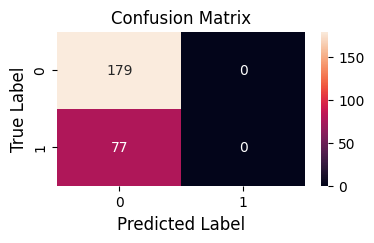


Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       179
           1       0.00      0.00      0.00        77

    accuracy                           0.70       256
   macro avg       0.35      0.50      0.41       256
weighted avg       0.49      0.70      0.58       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HAHV","lstm")

Epoch 1/20
32/32 [==============================] - 3s 23ms/step - loss: 0.6553 - accuracy: 0.6777 - val_loss: 0.5621 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6198 - accuracy: 0.7188 - val_loss: 0.5589 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6289 - accuracy: 0.7178 - val_loss: 0.5602 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6002 - accuracy: 0.7354 - val_loss: 0.5624 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6088 - accuracy: 0.7256 - val_loss: 0.5602 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6051 - accuracy: 0.7354 - val_loss: 0.5649 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5921 - accuracy: 0.7412 - val_loss: 0.5622 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

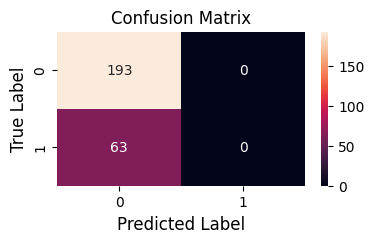


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       193
           1       0.00      0.00      0.00        63

    accuracy                           0.75       256
   macro avg       0.38      0.50      0.43       256
weighted avg       0.57      0.75      0.65       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("alpha","central","LAHV","lstm")

Epoch 1/20
32/32 [==============================] - 3s 23ms/step - loss: 0.5918 - accuracy: 0.7236 - val_loss: 0.5191 - val_accuracy: 0.7930
Epoch 2/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5629 - accuracy: 0.7705 - val_loss: 0.5158 - val_accuracy: 0.7930
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5491 - accuracy: 0.7734 - val_loss: 0.5145 - val_accuracy: 0.7930
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.5360 - accuracy: 0.7773 - val_loss: 0.5126 - val_accuracy: 0.7930
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.5432 - accuracy: 0.7725 - val_loss: 0.5116 - val_accuracy: 0.7930
Epoch 6/20
32/32 [==============================] - 0s 8ms/step - loss: 0.5436 - accuracy: 0.7744 - val_loss: 0.5132 - val_accuracy: 0.7930
Epoch 7/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5429 - accuracy: 0.7725 - val_loss: 0.5131 - val_accuracy: 0.7930
Epoch 8/20
32/32 [=

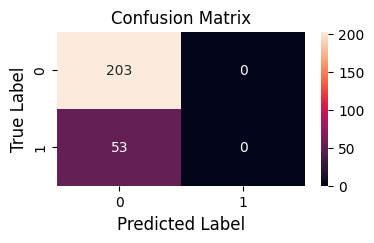


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       203
           1       0.00      0.00      0.00        53

    accuracy                           0.79       256
   macro avg       0.40      0.50      0.44       256
weighted avg       0.63      0.79      0.70       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("gamma","frontal","HALV","lstm")

Epoch 1/20
32/32 [==============================] - 3s 24ms/step - loss: 0.6157 - accuracy: 0.7197 - val_loss: 0.5633 - val_accuracy: 0.7539
Epoch 2/20
32/32 [==============================] - 0s 6ms/step - loss: 0.6009 - accuracy: 0.7451 - val_loss: 0.5697 - val_accuracy: 0.7539
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5920 - accuracy: 0.7422 - val_loss: 0.5671 - val_accuracy: 0.7539
Epoch 4/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5809 - accuracy: 0.7510 - val_loss: 0.5673 - val_accuracy: 0.7539
Epoch 5/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5791 - accuracy: 0.7490 - val_loss: 0.5659 - val_accuracy: 0.7539
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5854 - accuracy: 0.7510 - val_loss: 0.5699 - val_accuracy: 0.7539
Epoch 7/20
32/32 [==============================] - 0s 5ms/step - loss: 0.5786 - accuracy: 0.7510 - val_loss: 0.5669 - val_accuracy: 0.7539
Epoch 8/20
32/32 [=

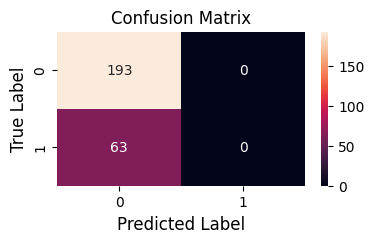


Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       193
           1       0.00      0.00      0.00        63

    accuracy                           0.75       256
   macro avg       0.38      0.50      0.43       256
weighted avg       0.57      0.75      0.65       256



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print_conf("alpha","parietal","LALV","lstm")